### Imports

In [1]:
import glob
import matplotlib.pyplot as plt
import multiprocessing as mp
import seaborn as sns
import numpy as np
np.random.seed(42)

from utils.loading import TICKER_PATHS, PLT_PATH
from utils.loading import read_ticker
from utils.preprocessing import preprocess_ticker
from utils.processing import process_all_tickers, daily_vol

In [10]:
TICKER_FILE = np.random.choice(TICKER_PATHS)

df = read_ticker(TICKER_FILE)
df_cleaned = preprocess_ticker(TICKER_FILE)

In [11]:
df_metaorder_duration = df_cleaned.groupby(['day', 'buyer_id']).agg(
    metaorder_start = ('datetime', 'min'),
    metaorder_end = ('datetime', 'max'),
).reset_index()
df_metaorder_duration['duration'] = df_metaorder_duration['metaorder_end'] - df_metaorder_duration['metaorder_start']
df_metaorder_duration['duration'] = df_metaorder_duration['duration'].dt.total_seconds()

In [12]:
df_metaorder_duration[(df_metaorder_duration['duration'] > 0) & (df_metaorder_duration['duration'] < 1000)]

,day,buyer_id,metaorder_start,metaorder_end,duration
7,2016-01-04,65.0,2016-01-04 15:06:59.369,2016-01-04 15:11:26.881,267.512
19,2016-01-05,79.0,2016-01-05 20:54:32.493,2016-01-05 20:54:37.289,4.796
21,2016-01-05,90.0,2016-01-05 20:36:06.590,2016-01-05 20:41:29.388,322.798
45,2016-01-08,7.0,2016-01-08 20:55:45.326,2016-01-08 20:58:59.764,194.438
102,2016-01-15,72.0,2016-01-15 16:37:56.301,2016-01-15 16:39:20.690,84.389
...,...,...,...,...,...
2386,2016-12-22,33.0,2016-12-22 14:40:19.960,2016-12-22 14:45:52.055,332.095
2391,2016-12-22,222.0,2016-12-22 14:36:17.295,2016-12-22 14:39:16.681,179.386
2408,2016-12-29,33.0,2016-12-29 20:37:48.925,2016-12-29 20:43:50.805,361.880
2410,2016-12-29,79.0,2016-12-29 16:30:22.221,2016-12-29 16:30:22.270,0.049


/Users/hamzezi/anaconda3/envs/fbd-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


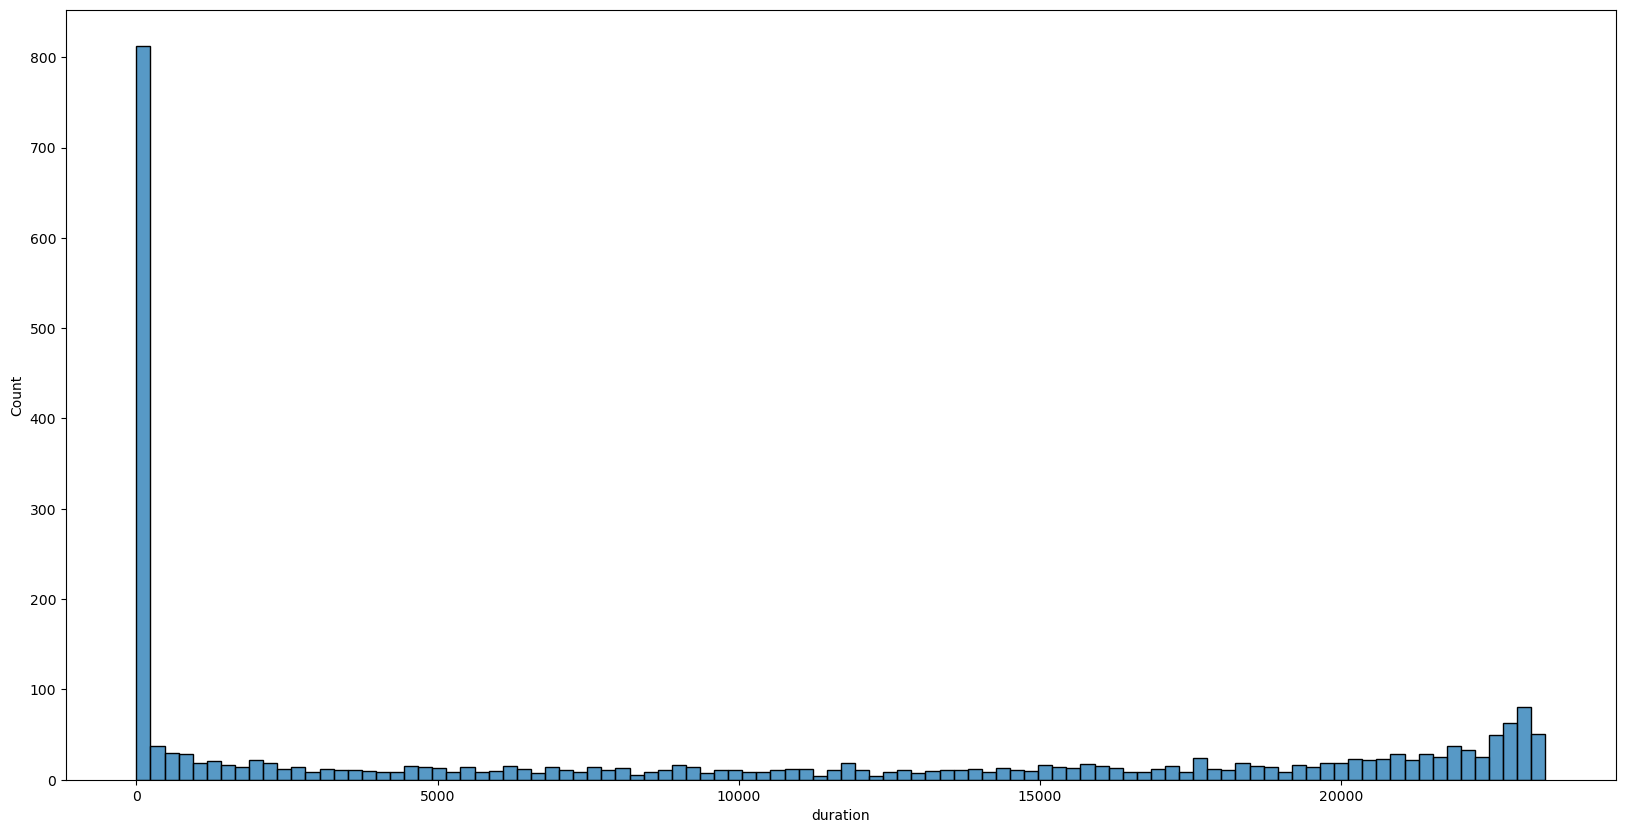

In [13]:
# plot distribution of metaorder durations
plt.figure(figsize=(20, 10))
sns.histplot(df_metaorder_duration['duration'], bins=100)
plt.show();

/Users/hamzezi/anaconda3/envs/fbd-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


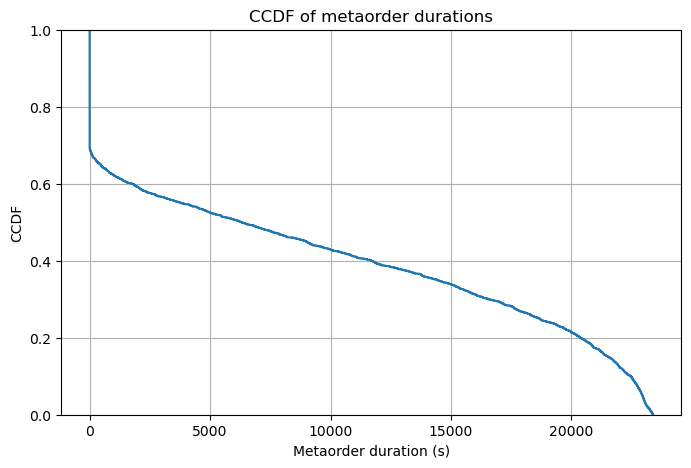

In [15]:
# plot ccdf of metaorder durations
plt.figure(figsize=(8, 5))
sns.ecdfplot(df_metaorder_duration['duration'], complementary=True)
plt.xlabel('Metaorder duration (s)')
plt.ylabel('CCDF')
plt.title('CCDF of metaorder durations')
plt.grid()
plt.savefig(PLT_PATH / 'metaorder_duration_ccdf.png', dpi=300)
plt.show();